Create database

Next steps:
- Show by ingredient (i.e. top fat delivering ingredients, etc.)
- Calc net carbs only when I want to use the information in dashboard, not on top (so I don't have to carry it with me all along the way when doing manipulations).

In [14]:
%run make_data.ipynb
%store -r myfoods

%run meals.ipynb
%store -r pa_meals fa_meals

Stored 'foods' (DataFrame)
Stored 'myfoods' (DataFrame)
Stored 'pa_meals' (dict)
Stored 'fa_meals' (dict)


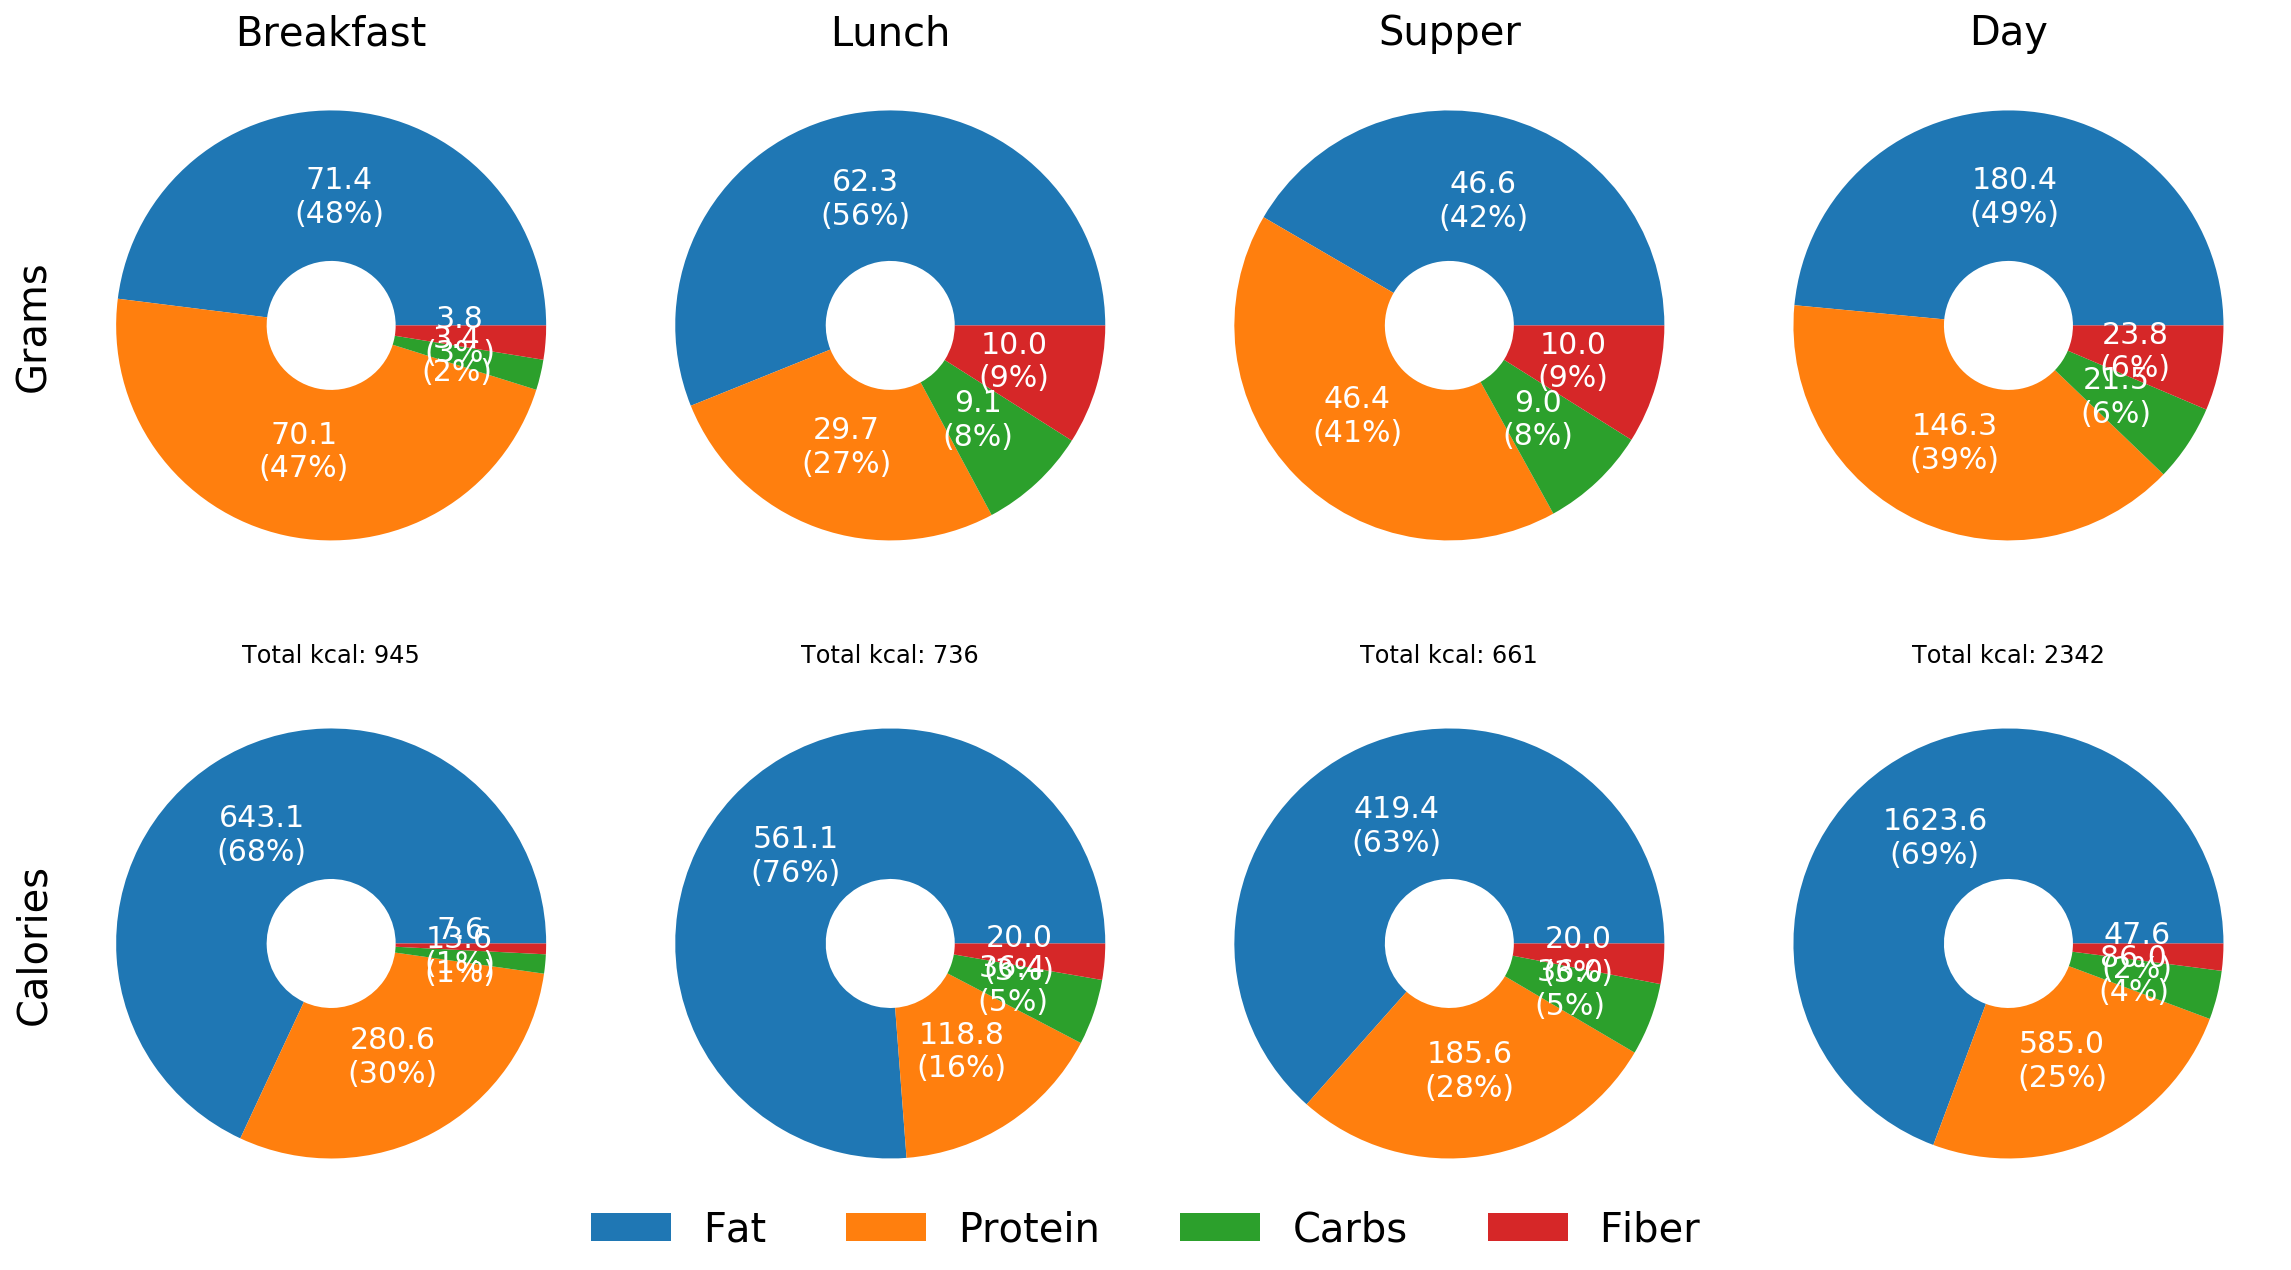

In [15]:
def calc_meal_nuts(data, meal):
    
    def make_multiindex(df):
        measure = df.columns.str.extract('^(.+?)_', expand=False)
        nutrient = df.columns.str.extract('_(.+?)$', expand=False)
        tuples = zip(measure, nutrient)
        idx = pd.MultiIndex.from_tuples(tuples, names=['measure', 'nutrient'])
        df.columns = idx
        return df
    
    def read(data):
        columns = ['calories', 'fat', 'protein', 'carbs', 'fiber']
        macros = ['fat', 'protein', 'carbs', 'fiber']
        portions = list(meal.values())   
        df = (data
              .loc[data.index.isin(meal), columns]
              .reindex(meal) # Order rows for portion multiplication
              .multiply(portions, axis=0)
              .assign(total=lambda df: df[macros].sum(axis=1))
              .add_prefix('grams_')
              .rename(columns = {'grams_calories': 'cals_total'})
              .assign(cals_fat = lambda df: df.grams_fat * 9)
              .assign(cals_protein = lambda df: df.grams_protein * 4)
              .assign(cals_carbs = lambda df: df.grams_carbs * 4)
              .assign(cals_fiber = lambda df: df.grams_fiber * 2)
#               .assign(cals_net_carbs=lambda df: df.grams_net_carbs * 4)
              .pipe(make_multiindex)
              .stack()
              .swaplevel(0, 1)
              .sort_index())
        
        df[df < 0] = 0
        return df

    return read(data)


def make_nuts_dict(meals):
    meal_nuts = {meal: calc_meal_nuts(myfoods, meals[meal]).sum(level='nutrient') for meal in meals}
    meal_nuts['Day'] = sum([meal_nuts[meal] for meal in meal_nuts])
    return meal_nuts


def make_dashboard(meals):
        
    rows = ['fat', 'protein', 'carbs', 'fiber']
    
    def make_doughnut(meal_data, column, axis, meal_num, meal_name):
        nuts = meal_data.loc[rows]
        
        def labs(pct, nuts):
            absolute = pct / 100 * nuts[column].sum()
            if pct < 0.5:
                return f''
            else:
                return f'{absolute:.1f}\n({pct:.0f}%)'

        ax[axis, meal_num].set_title(f'Total kcal: {nuts[column].sum():.0f}')
        ax[axis, meal_num].pie(nuts[column],
                               autopct=lambda pct: labs(pct, nuts),
                               textprops=dict(color='white', size=15),
                               wedgeprops=dict(width=.7))
        
        
    fig, ax = plt.subplots(2, len(meals), figsize=(16, 9))

    # Plot grams (top) and calories (bottom) for each meal
    for meal_num, meal_name in enumerate(meals):
        make_doughnut(meals[meal_name], 'grams', 0, meal_num, meal_name)
        make_doughnut(meals[meal_name], 'cals', 1, meal_num, meal_name)

    # Set column and row labels
    ax[0, 0].set_ylabel('Grams', fontsize=20)
    ax[1, 0].set_ylabel('Calories', fontsize=20)
    for col, name in enumerate(meals):
        ax[0, col].set_title(name, fontsize=20)

    legend_labs = [r.capitalize().replace('_', ' ') for r in rows]
    fig.legend(legend_labs, loc='lower center', ncol=4, fontsize=20, 
               framealpha=0, borderpad=0)
    fig.tight_layout()
    
    

meals = {
    
    'Breakfast': {
        'cauliflower': 1,
        'cheese': 1.5,
        'eggs': 2,
        'spinach': 0.5,
    },

    'Lunch': {
        'lettuce': 1.5,
        'nuts and seed mix': .5,        
        'olive oil': .3,
        'tofu': 2,
    },

    'Supper': {
        'avocado': 2,
        'butter': 0,
        'trout': 2,
        'vegetables': 2,
    }
}
    
meal_nuts = make_nuts_dict(meals)
make_dashboard(meal_nuts)

# Development

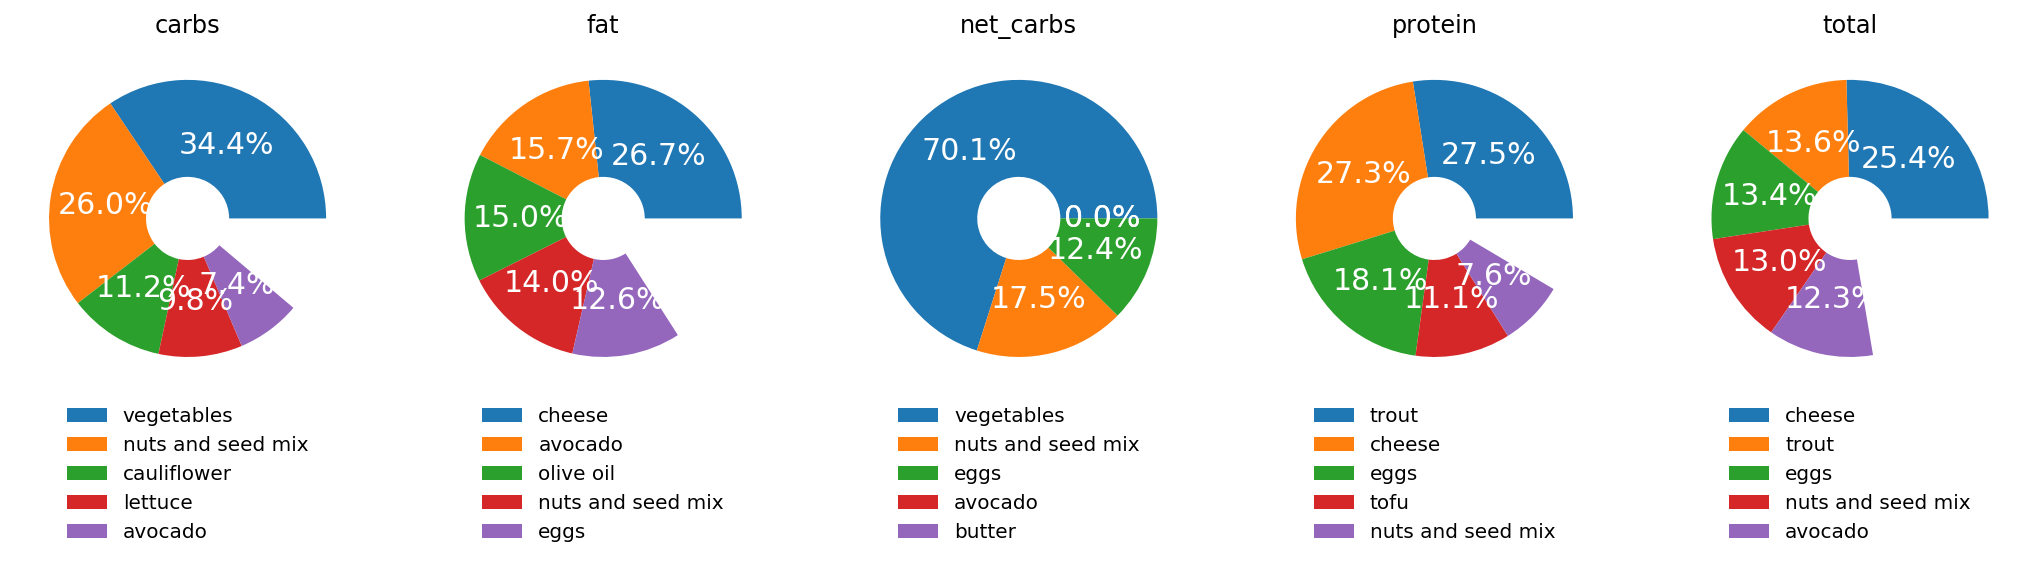

In [3]:
meals = {
    
    'Breakfast': {
        'cauliflower': 1,
        'cheese': 1.5,
        'eggs': 2,
        'spinach': 0.5,
    },

    'Lunch': {
        'lettuce': 1.5,
        'nuts and seed mix': .5,        
        'olive oil': .3,
        'tofu': 2,
    },

    'Supper': {
        'avocado': 2,
        'butter': 0,
        'trout': 2,
        'vegetables': 2,
    }
}

def make_nuts_dict(meals):
    meal_nuts = {meal: calc_meal_nuts(myfoods, meals[meal]) for meal in meals}
    meal_nuts['Day'] = pd.concat(meal_nuts).droplevel(level=0).sum(level=['nutrient', 'name']).sort_index()
    return meal_nuts

complete = make_nuts_dict(meals)['Day']
day = make_nuts_dict(meals)['Day']

def get_cals_ingred(group, top_n):
    group['cals_share'] = group.cals / group.cals.sum()
    return group.sort_values('cals_share', ascending=False)[:top_n]

shares = day.groupby('nutrient').apply(get_cals_ingred, 5).droplevel(level=0)


def make_doughnut(meal_data, column, meal_num, meal_name):
        
        ax[meal_num].set_title(f'{nut}')
        ax[meal_num].pie(meal_data[column],
                               autopct='%1.1f%%',
                               textprops=dict(color='white', size=15),
                               wedgeprops=dict(width=.7))
        ax[meal_num].legend(meal_data.index, loc='lower center', borderpad=-8, framealpha=0)


        
nuts = shares.index.levels[0].unique()

fig, ax = plt.subplots(1, len(nuts), figsize=(18,10))

for idx, nut in enumerate(nuts):
    make_doughnut(shares.loc[nut], 'cals_share', idx, nut)



Outline:
1. Fetch meal data from database
2. Calculate nutrients for each meal and for daily total
3. Prepare data for graphics
4. Create graphics
5. Print dashboard

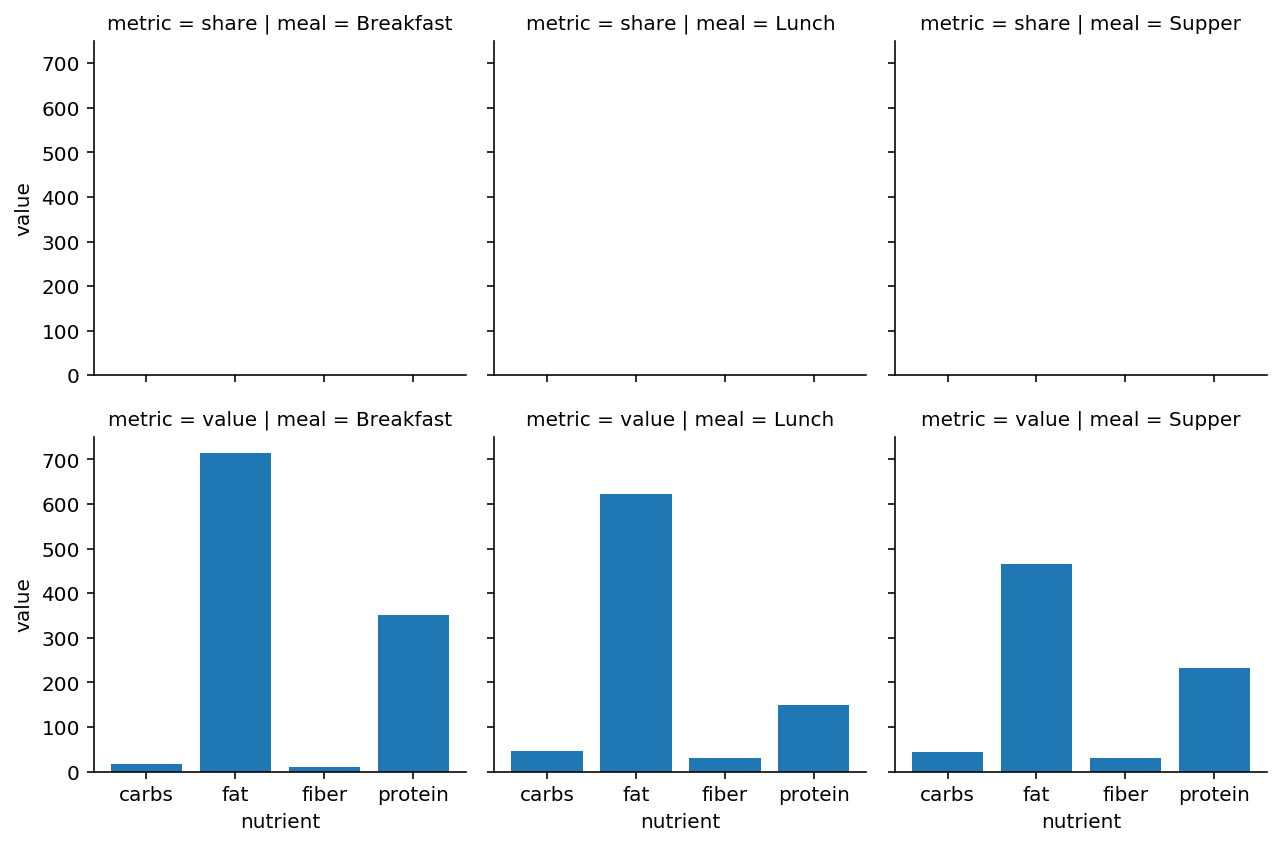

In [99]:
meals = {
    
    'Breakfast': {
        'cauliflower': 1,
        'cheese': 1.5,
        'eggs': 2,
        'spinach': 0.5,
    },

    'Lunch': {
        'lettuce': 1.5,
        'nuts and seed mix': .5,        
        'olive oil': .3,
        'tofu': 2,
    },

    'Supper': {
        'avocado': 2,
        'butter': 0,
        'trout': 2,
        'vegetables': 2,
    }
}


def calc_nuts(meals, add_total=True):
    """Calculate nutrient content for each meal and for daily total."""
    
    def calc_meal_nuts(meal_dic, data=myfoods):
        """Calculate nutrient content for a meal."""
        columns = ['fat', 'protein', 'carbs', 'fiber']
        cals_per_g = {'fat': 9, 'carbs': 4, 'protein': 4, 'fiber': 2} 
        
        def calc_share(group):
            group['share'] = group.value / group.value.sum()
            return group
        
        df = (data
              .loc[data.index.isin(meal_dic), columns]
              .reset_index()
              .melt(id_vars='ingredient', var_name='nutrient', value_name='grams')
              .assign(portion = lambda x: x.ingredient.map(meal_dic))
              .assign(grams = lambda x: x.grams * x.portion)
              .assign(cals_per_gram = lambda x: x.nutrient.map(cals_per_g))
              .assign(cals = lambda x: x.grams * x.cals_per_gram)
              .drop(['cals_per_gram', 'portion'], axis=1)
              .melt(id_vars=['ingredient', 'nutrient'],
                    var_name='measure')
              .groupby('measure')
              .apply(calc_share)
              .melt(id_vars=['ingredient', 'nutrient', 'measure'], 
                    var_name='metric'))

        return df
    
    nuts = {meal: calc_meal_nuts(meals[meal]) for meal in meals}
   
    if add_total:
        cols = ['ingredient', 'nutrient']
        nuts['Day'] = (pd.concat(nuts.values()).groupby(cols, as_index=False).sum())
        
    pieces = []
    for meal in nuts:
        df = nuts[meal]
        df['meal'] = meal
        pieces.append(df)
    
    return pd.concat(pieces)
    

def make_meals_data(data):
    data = data.groupby(['meal', 'nutrient', 'metric'], as_index=False).sum()
    return data.sort_values(['metric', 'meal', 'nutrient'])


nuts = calc_nuts(meals, add_total=False)
meals_data = make_meals_data(nuts)
# nuts_data = make_nuts_data(nuts)

# Need to correct shares in daily total, which sum to n meals rather than 1

data = meals_data

import seaborn as sns

g = sns.FacetGrid(data, col='meal', row='metric')
g.map(plt.bar, 'nutrient', 'value')

In [ ]:


def get_top(group, var, n):
    return group.sort_values(var, ascending=False)[:n]


def make_nuts_data(data):
    result = {meal: data[meal].groupby('nutrient')
              .apply(get_top, 'grams', 3)
              .reset_index(drop=True) for meal in data}
    return result


def make_doughnut(meal_data, column, meal_num, meal_name):
        
        ax[meal_num].set_title(f'{nut}')
        ax[meal_num].pie(meal_data[column],
                               autopct='%1.1f%%',
                               textprops=dict(color='white', size=15),
                               wedgeprops=dict(width=.7))
        ax[meal_num].legend(meal_data.index, loc='lower center', borderpad=-8, framealpha=0)


